# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports of packages:

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import datetime
from datetime import date, timedelta
from plotly.subplots import make_subplots
from unittest import skip
import chart_studio
import chart_studio.plotly as py


# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject
import pandas as pd
import requests

           Dato         Safe      Optimum          Max   Responsible  \
1813 2023-03-29  3983.423486  5359.255150  7023.261149  11239.296036   
1814 2023-03-30  3989.906942  5382.447224  7070.444714  11306.482668   
1815 2023-03-31  3995.041821  5386.944102  7083.429276  11327.156115   
1816 2023-04-03  3989.001183  5373.858083  7054.494138  11316.565444   
1817 2023-04-04  3991.530535  5374.700449  7055.183160  11311.857773   

              Dmax  
1813  31583.760310  
1814  32018.341684  
1815  32139.975534  
1816  31847.874304  
1817  31853.561875  


Import of datasets:

In [8]:
url_historik = 'https://github.com/NumEconCopenhagen/projects-2023-siuuu/blob/main/dataproject/Kurshistorik%2C%20safemax.xlsx?raw=true'
response_historik = requests.get(url_historik)
content_historik = response_historik.content
# Creating dataframe from excel file that contains the historical data
DataSafeMax = pd.read_excel(content_historik, sheet_name='KursHistorisk', usecols="B:G", skiprows=2, engine='openpyxl')
DataSafeMax = DataSafeMax.rename(columns={'DMax': 'Dmax'})
# Creating dataframe from excel file that contains the historical data
Kurserhistorik = pd.read_excel(content_historik, sheet_name='KurserHistorisk', engine='openpyxl')
Kurserhistorik.drop(Kurserhistorik.columns[0], axis=1, inplace=True)
# Now we want to create a new dataframe that contains the historical data for the funds, why we import a nwe excel file
url_indeks = 'https://github.com/NumEconCopenhagen/projects-2023-siuuu/blob/main/dataproject/IndeksData_udenmakro.xlsx'
response_indeks = requests.get(url_indeks)
content_indeks = response_indeks.content

url_indeks = 'https://github.com/NumEconCopenhagen/projects-2023-siuuu/blob/main/dataproject/IndeksData_udenmakro.xlsx?raw=true'
response_indeks = requests.get(url_indeks)
content_indeks = response_indeks.content
# The dataframe is now created
IndeksData = pd.read_excel(content_indeks, sheet_name='Fonde', usecols="C,E, G:H, AB:AC, HM:HN, HQ:HR", skiprows=1, engine='openpyxl')


   2023-04-11 00:00:00  Unnamed: 1       NYKRINDX Index 2023-04-11 00:00:00.1  \
0                  NaN         NaN                 Dato               PX_LAST   
1                  NaN         NaN                  NaN                308.02   
2                  NaN         NaN  2008-11-14 00:00:00                308.22   
3                  NaN         NaN  2008-11-17 00:00:00                309.27   
4                  NaN         NaN  2008-11-18 00:00:00                309.35   

   NykreditIndex  Unnamed: 5       NDUEACWF Index MSCIWorldAC  \
0            NaN         NaN                 Dato     PX_LAST   
1         308.02         NaN                  NaN   521.02488   
2         308.22         NaN  2008-11-14 00:00:00   502.88426   
3         309.27         NaN  2008-11-17 00:00:00   491.40308   
4         309.35         NaN  2008-11-18 00:00:00   493.18141   

   2023-04-11 00:00:00.2  MSCI ACWI Net Total Return USD Index  ...  \
0                    NaN                           

In [2]:
print(DataSafeMax.tail())
print(Kurserhistorik.tail())

           Dato         Safe      Optimum          Max   Responsible  \
1813 2023-03-29  3983.423486  5359.255150  7023.261149  11239.296036   
1814 2023-03-30  3989.906942  5382.447224  7070.444714  11306.482668   
1815 2023-03-31  3995.041821  5386.944102  7083.429276  11327.156115   
1816 2023-04-03  3989.001183  5373.858083  7054.494138  11316.565444   
1817 2023-04-04  3991.530535  5374.700449  7055.183160  11311.857773   

              Dmax  
1813  31583.760310  
1814  32018.341684  
1815  32139.975534  
1816  31847.874304  
1817  31853.561875  
           Dato         Safe      Optimum          Max   Responsible  \
5108 2022-12-27  4046.650081  5550.487165  7368.643177  11753.200598   
5109 2022-12-28  4046.650081  5550.487165  7368.643177  11753.200598   
5110 2022-12-29  4046.650081  5550.487165  7368.643177  11753.200598   
5111 2022-12-30  4046.650081  5550.487165  7368.643177  11753.200598   
5112 2022-12-31  4046.650081  5550.487165  7368.643177  11753.200598   

        

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Janze\\OneDrive\\Skrivebord\\Introduction_to_programming\\projects-2023-siuuu\\dataproject\\Kurshistorik, safemax.xlsx'

In [14]:
stock_list = ['SPY']
print('stock_list:', stock_list)
data = yf.download(stock_list, start="2015-01-01", end="2020-02-21")
print('data fields downloaded:', set(data.columns.get_level_values(0)))
data.tail()

stock_list: ['SPY']
[*********************100%***********************]  1 of 1 completed
data fields downloaded: {'Low', 'Volume', 'Close', 'High', 'Open', 'Adj Close'}


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-02-13,335.859985,338.119995,335.559998,337.059998,320.093842,54501900
2020-02-14,337.510010,337.730011,336.200012,337.600006,320.606689,64582200
2020-02-18,336.510010,337.670013,335.209991,336.730011,319.780487,57226200
2020-02-19,337.790009,339.079987,337.480011,338.339996,321.309387,48814700
2020-02-20,337.739990,338.640015,333.679993,336.950012,319.989441,74163400


In [25]:
tsla = yf.Ticker("TSLA")

{'symbol': 'TSLA',
 'twoHundredDayAverageChangePercent': -0.08075416,
 'fiftyTwoWeekLowChangePercent': 0.9469601,
 'averageAnalystRating': '2.4 - Buy',
 'language': 'en-US',
 'earningsTimestampEnd': 1681934400,
 'regularMarketDayRange': '196.47 - 198.47',
 'epsForward': 5.47,
 'regularMarketDayHigh': 198.47,
 'twoHundredDayAverageChange': -17.413284,
 'twoHundredDayAverage': 215.63329,
 'askSize': 8,
 'bookValue': 14.129,
 'fiftyTwoWeekHighChange': -186.07,
 'marketCap': 668181790720,
 'fiftyTwoWeekRange': '101.81 - 384.29',
 'fiftyDayAverageChange': 9.487198,
 'firstTradeDateMilliseconds': 1277818200000,
 'exchangeDataDelayedBy': 0,
 'averageDailyVolume3Month': 173621083,
 'trailingAnnualDividendRate': 0.0,
 'fiftyTwoWeekLow': 101.81,
 'market': 'us_market',
 'regularMarketVolume': 7433035,
 'quoteSourceName': 'Nasdaq Real Time Price',
 'messageBoardId': 'finmb_27444752',
 'priceHint': 2,
 'exchange': 'NMS',
 'sourceInterval': 15,
 'regularMarketDayLow': 196.47,
 'shortName': 'Tesla, 

# Read and clean data

Import your data, either through an API or manually, and load it. 

## Explore each data set

In order to be able to **explore the raw data**, you may provide **static** and **interactive plots** to show important developments 

**Interactive plot** :

In [2]:
def plot_func():
    # Function that operates on data set
    pass

widgets.interact(plot_func, 
    # Let the widget interact with data through plot_func()    
); 


interactive(children=(Output(),), _dom_classes=('widget-interact',))

Explain what you see when moving elements of the interactive plot around. 

# Merge data sets

Now you create combinations of your loaded data sets. Remember the illustration of a (inner) **merge**:

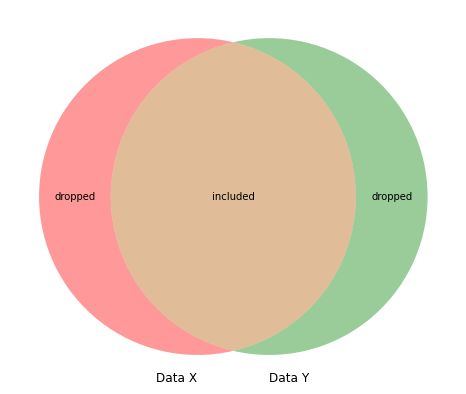

In [3]:
plt.figure(figsize=(15,7))
v = venn2(subsets = (4, 4, 10), set_labels = ('Data X', 'Data Y'))
v.get_label_by_id('100').set_text('dropped')
v.get_label_by_id('010').set_text('dropped' )
v.get_label_by_id('110').set_text('included')
plt.show()

Here we are dropping elements from both data set X and data set Y. A left join would keep all observations in data X intact and subset only from Y. 

Make sure that your resulting data sets have the correct number of rows and columns. That is, be clear about which observations are thrown away. 

**Note:** Don't make Venn diagrams in your own data project. It is just for exposition. 

# Analysis

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

MAKE FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

# Conclusion

ADD CONCISE CONLUSION.